In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

# from keras_unet_collection import models

2023-10-25 14:57:33.895092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
epoch_num = 10
bsize =  32

# fp = '/rc_scratch/reba1583/unet_testing_results/fullAR_epochs'+str(epoch_num)+'_bsize'+str(bsize)+'/'
fp = '/rc_scratch/reba1583/unet_testing_results/epochs'+str(epoch_num)+'_bsize'+str(bsize)+'/'


y_pred = np.loadtxt(fp+'pred.csv',delimiter=",", dtype=float)
y_pred = y_pred.reshape((np.shape(y_pred)[0],256, 32))
y_pred_ravel = y_pred.ravel()

y_val = np.loadtxt(fp+'val.csv',delimiter=",", dtype=float)
y_val = y_val.reshape((np.shape(y_val)[0],256, 32))
y_val_ravel = y_val.ravel()

## Compare Distributions

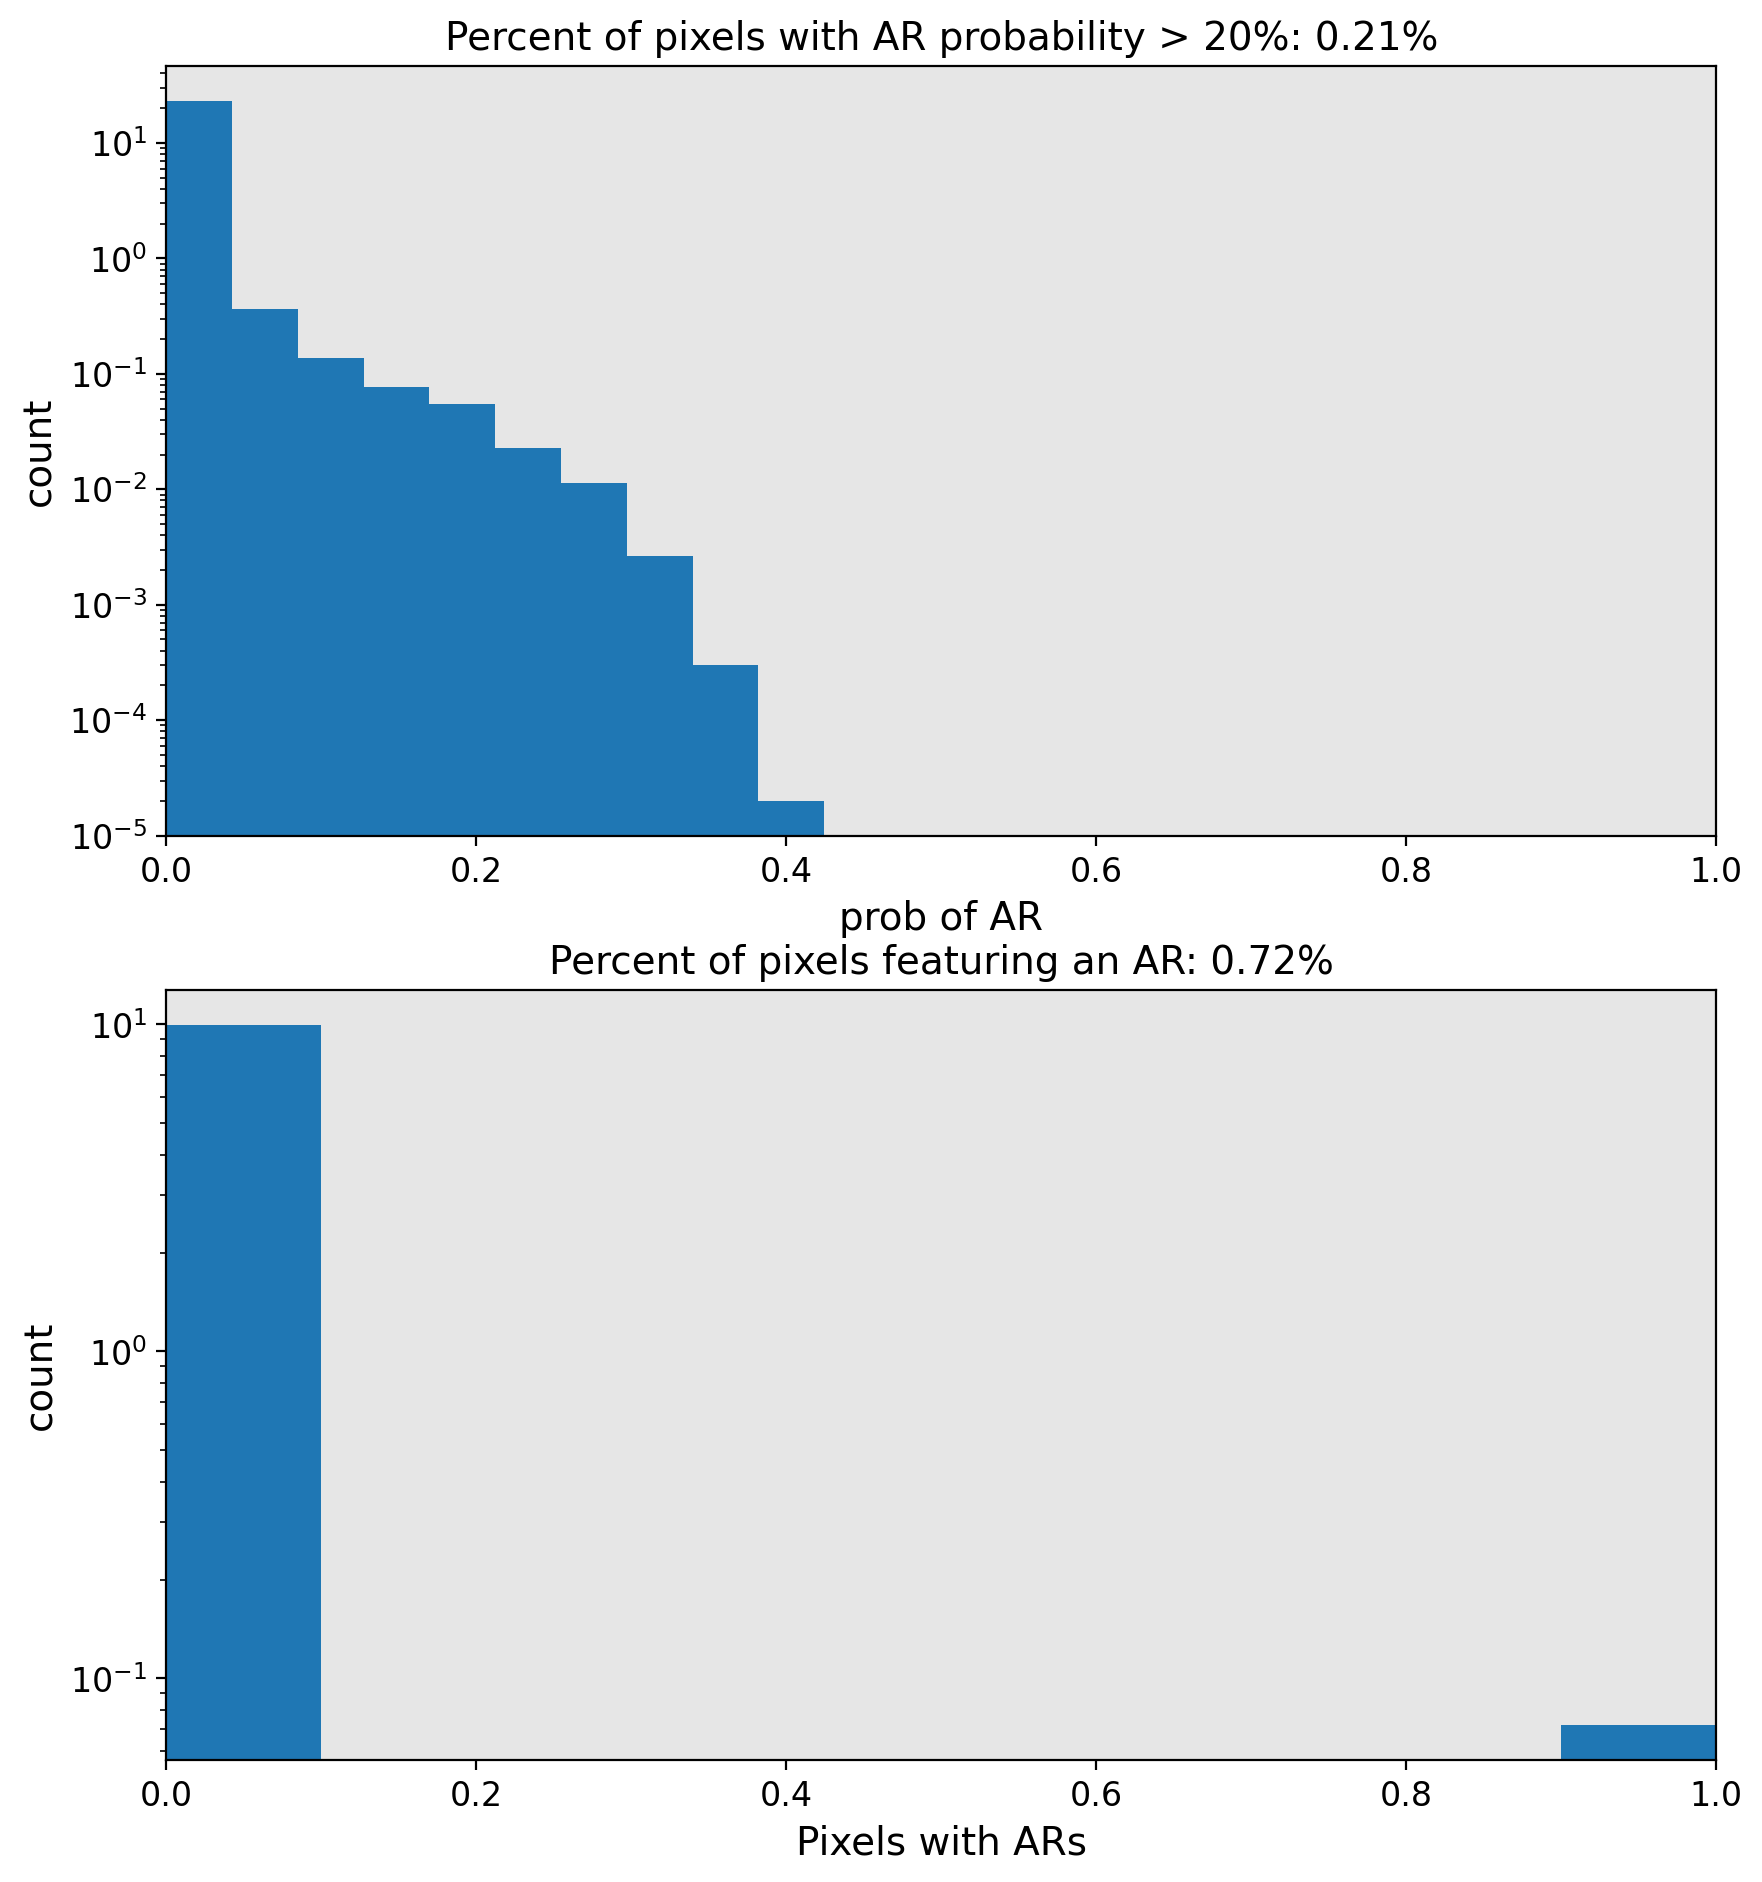

In [3]:
fig,ax = plt.subplots(2,1,figsize=(10, 11))

ax[0].set_title('Percent of pixels with AR probability > 20%: '+ str(np.round(len(np.where(y_pred_ravel>.2)[0])/len(y_pred_ravel)*100,2))+ '%')
ax[0].hist(y_pred_ravel, density = True)
ax[0].set_xlabel('prob of AR')
ax[0].set_ylabel('count')
ax[0].set_xlim([0,1])
ax[0].set_yscale('log')


ax[1].set_title('Percent of pixels featuring an AR: '+ str(np.round(len(np.where(y_val_ravel==1)[0])/len(y_val_ravel)*100,2))+ '%')
ax[1].hist(y_val_ravel, density = True)
ax[1].set_xlabel('Pixels with ARs')
ax[1].set_ylabel('count')
ax[1].set_xlim([0,1])
ax[1].set_yscale('log')

## Compare One timestep 

In [4]:
basins = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
basins = basins.interp(lon = np.linspace(-180,180,256), lat = np.linspace(-90,-60,32))
basins = basins.Zwallybasins > 0


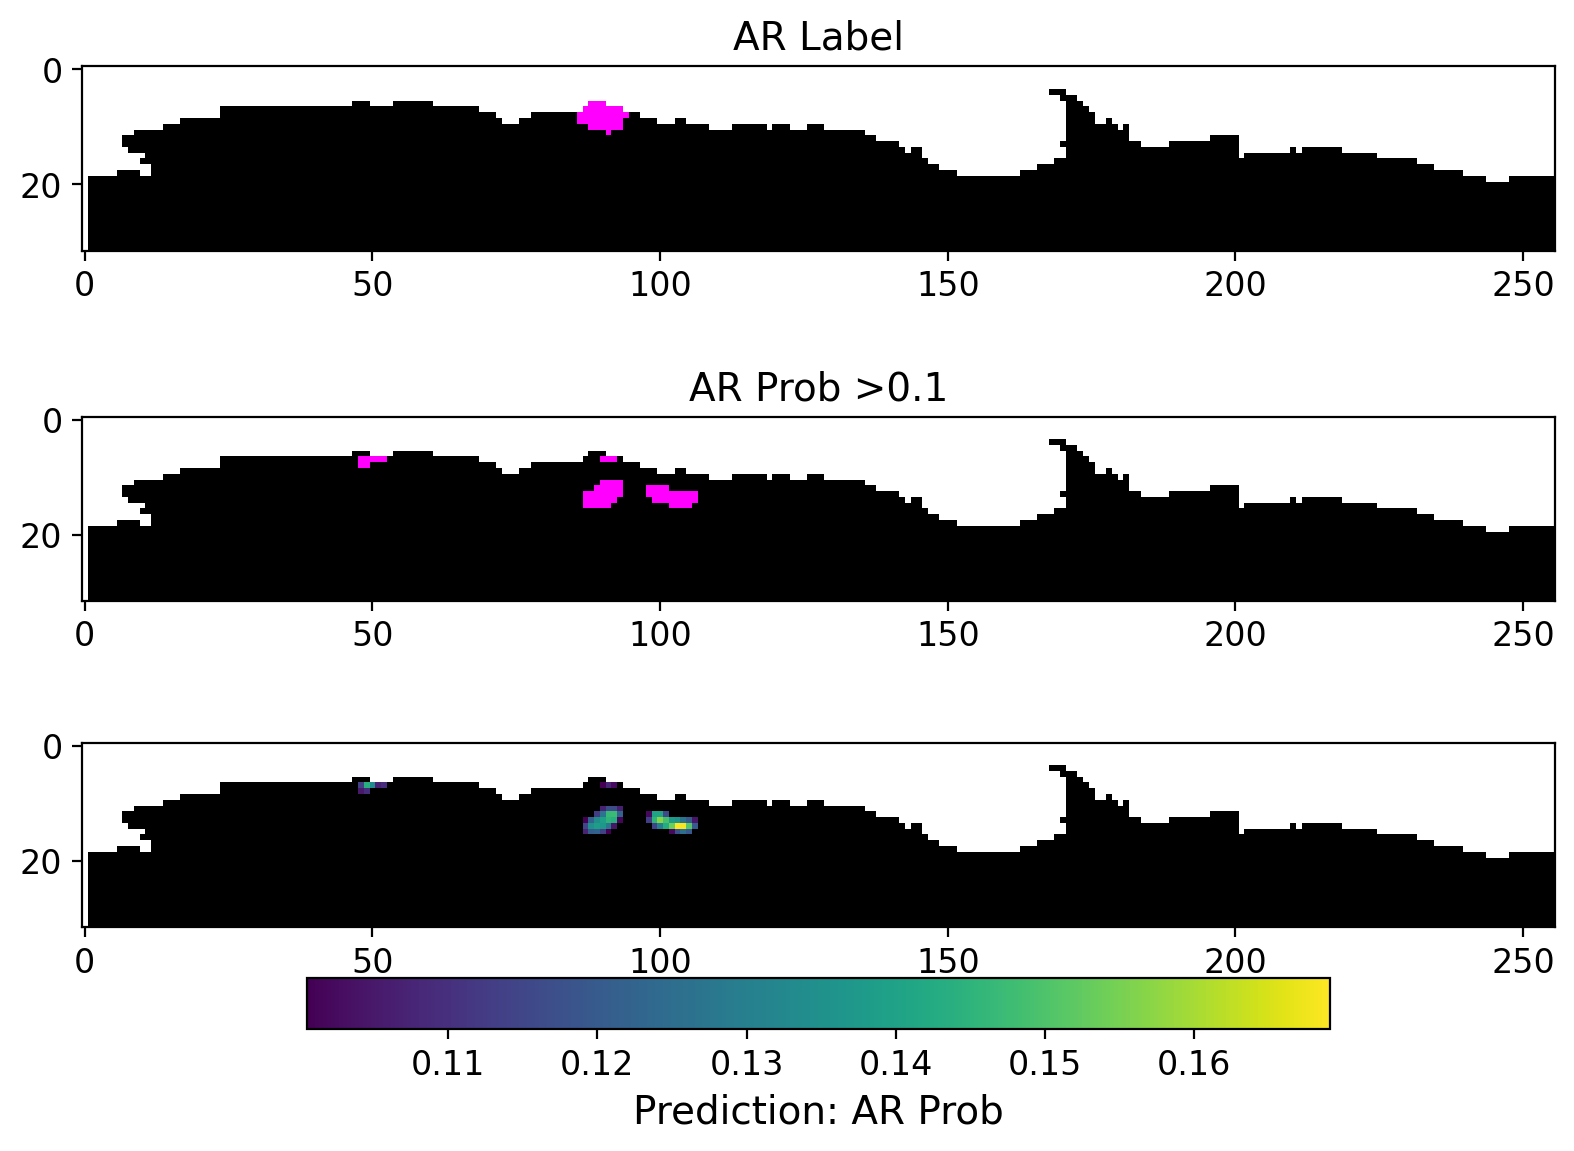

In [17]:
t = 40

prob_cutoff = .1

y_pred_example = np.where(y_pred[t]>prob_cutoff,1,np.nan)
y_val_example = np.where(y_val[t]>prob_cutoff,1,np.nan)
y_pred_gradient = np.where(y_pred[t]>prob_cutoff,y_pred[t],np.nan)



fig,axes = plt.subplots(3,1,figsize=(8,6),facecolor='w')

axes[0].imshow(np.flip(basins), cmap = 'Greys')
pm = axes[0].imshow(np.flip(y_val_example.T), cmap = 'spring')
axes[0].set_title('AR Label')

axes[1].imshow(np.flip(basins), cmap = 'Greys')
pm = axes[1].imshow(np.flip(y_pred_example.T), cmap = 'spring')
axes[1].set_title('AR Prob >'+str(prob_cutoff))

axes[2].imshow(np.flip(basins), cmap = 'Greys')
pm = axes[2].imshow(np.flip(y_pred_gradient.T))
plt.colorbar(pm,ax=axes[2],label='Prediction: AR Prob', orientation = 'horizontal')

plt.tight_layout()

### Evaluate

In [9]:
eval_data = pd.read_csv(fp+'evaluation.csv')
pods = np.where(np.isnan(np.array(eval_data.pods)), 0, eval_data.pods)
srs =np.where(np.isnan(np.array(eval_data.srs)), 0, eval_data.srs)

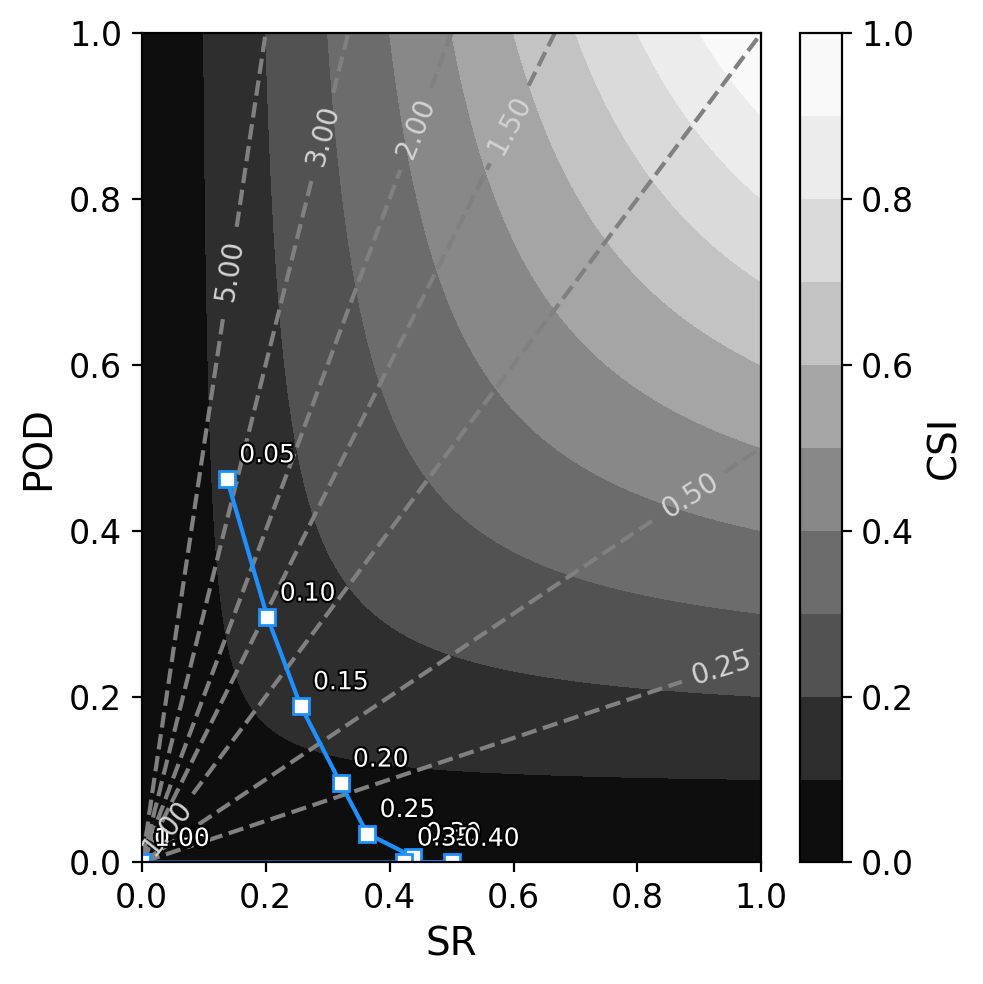

In [11]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)


#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(srs[i]+0.02,pods[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout();

In [12]:
eval_data

,pods,srs,csis
0,0.462540,0.137488,0.118549
1,0.295620,0.202897,0.136774
2,0.188776,0.256557,0.122025
3,0.095580,0.320847,0.079497
4,0.034799,0.363959,0.032805
5,0.006644,0.438211,0.006588
6,0.000450,0.424084,0.000450
7,0.000017,0.500000,0.000017
8,0.000000,NaN,0.000000
9,0.000000,NaN,0.000000


In [295]:
# Evaluate including calculation of pods, srs

TypeError: 'enumerate' object is not subscriptable

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

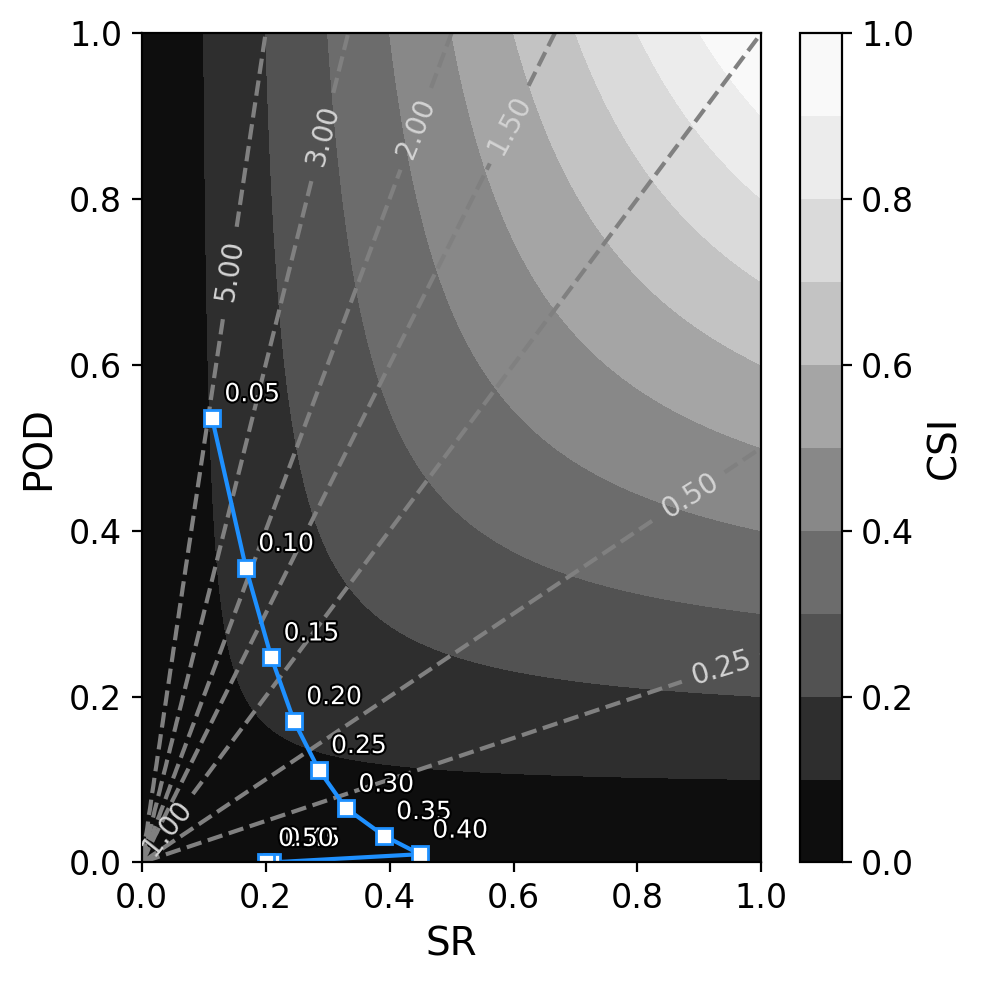

In [78]:

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_val_ravel,y_pred_ravel)
fps = fp(y_val_ravel,y_pred_ravel)
fns = fn(y_val_ravel,y_pred_ravel)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

In [ ]:
## the drop at .5 is likely because there are no (or negligeable) pixels with that probability 

In [226]:
def make_landfalling_y(y_data, cutoff = 0):
    basins = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
    basins = basins.interp(lon = np.linspace(-180,180,256), lat = np.linspace(-90,-60,32))
    basins = basins.Zwallybasins > 0
    basins_3d = np.repeat(basins.values[np.newaxis,:,:], np.shape(y_val)[0], axis = 0)


    y_data = np.transpose(y_data,(0,2,1))
    y_data_land = np.where(basins_3d, y_data, 0)
    
    y_data_land = y_data_land[np.where(np.max(y_data_land, axis = (1,2)) >cutoff)[0]]

    return(y_data_land.ravel())

In [227]:
y_val_land_ravel = make_landfalling_y(y_val)
y_pred_land_ravel = make_landfalling_y(y_pred)

In [228]:
np.shape(y_pred_land_ravel)

(25034752,)

In [229]:
np.shape(y_pred_ravel)

(25034752,)

In [230]:
np.shape(y_val)

(3056, 256, 32)

In [254]:
ds_val_xr = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Training_data/train.nc')
ds_val_xr

<xarray.Dataset>
Dimensions:    (time: 14260, lon: 256, lat: 32, n_channel: 8)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-03T06:00:00 ... 2019-12-31
  * n_channel  (n_channel) object 'IWV' 'EFLUX' 'LWTNET' 'SF' 'SLP' 'T' 'U' 'V'
Dimensions without coordinates: lon, lat
Data variables:
    features   (time, lon, lat, n_channel) float64 ...
    labels_2d  (time, lon, lat) int64 ...

In [260]:
y_val = np.loadtxt('/rc_scratch/reba1583/unet_testing_results/fullAR_epochs10_bsize128/val.csv',delimiter=",", dtype=float)
y_val = y_val.reshape((np.shape(y_val)[0],256, 32))

np.shape(y_pred)

(3056, 256, 32)

In [258]:
8192/256

32.0

In [257]:
test2 = np.loadtxt('/rc_scratch/reba1583/unet_testing_results/pred_epochs10_bsize64.csv',delimiter=",", dtype=float)
np.shape(test2)

(3056, 8192)

In [243]:
np.shape(test.ravel())

(51429376,)

In [255]:
14260/128

111.40625

In [183]:
y_val = np.transpose(y_val,(0,2,1))
basins_3d = np.repeat(basins.values[np.newaxis,:,:], np.shape(y_val)[0], axis = 0)
y_val_land = np.where(basins_3d, y_val, 0)

In [189]:
np.shape(y_val_land)



(3056, 32, 256)

In [199]:
np.shape(y_val_land[np.where(np.max(y_val_land, axis = (1,2)) ==1)[0]])

(1511, 32, 256)

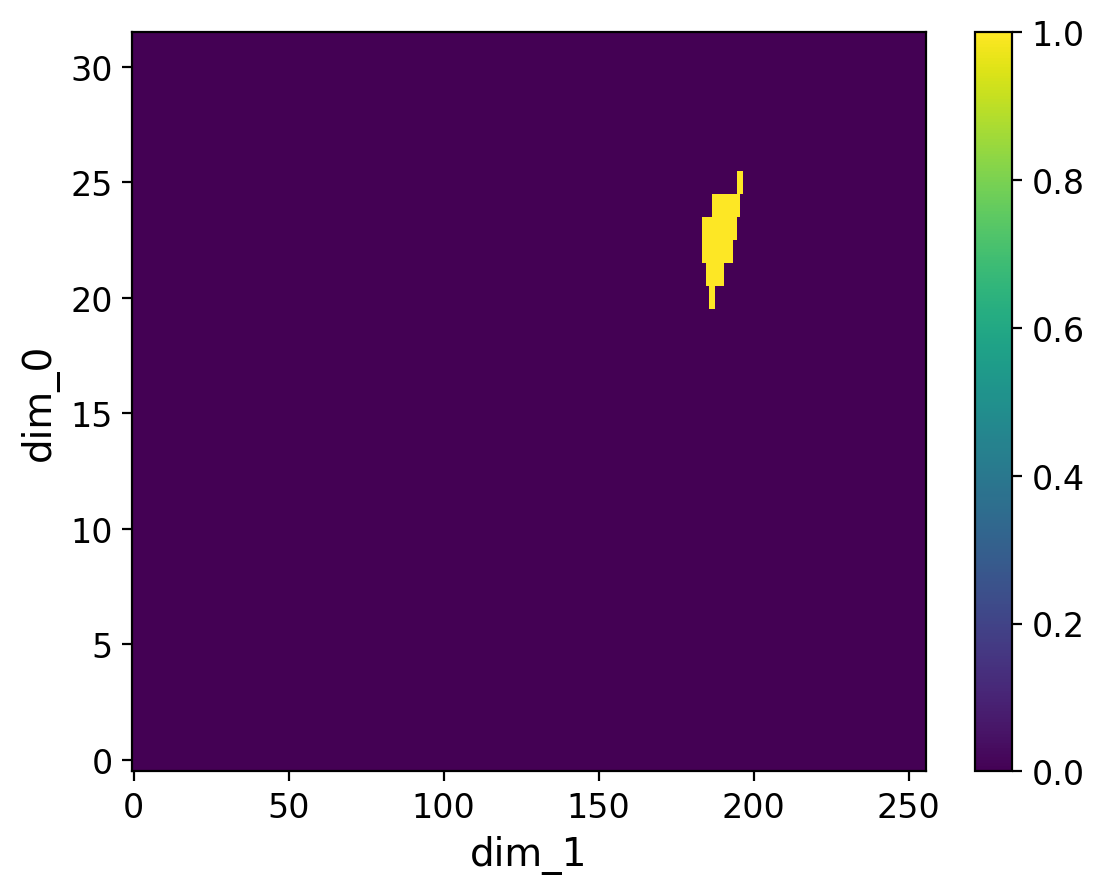

In [185]:
n = 63
xr.DataArray(y_val_land[n]).plot()

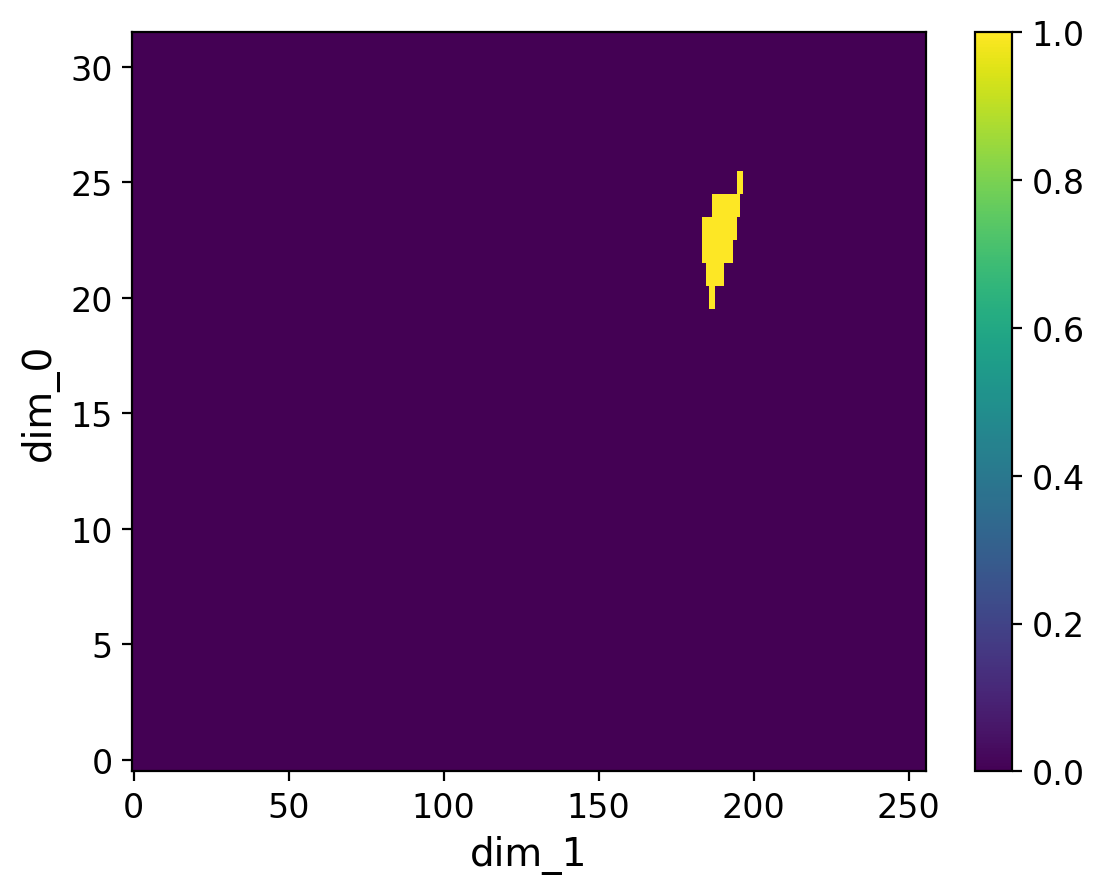

In [186]:
xr.DataArray(y_val[n]).plot()

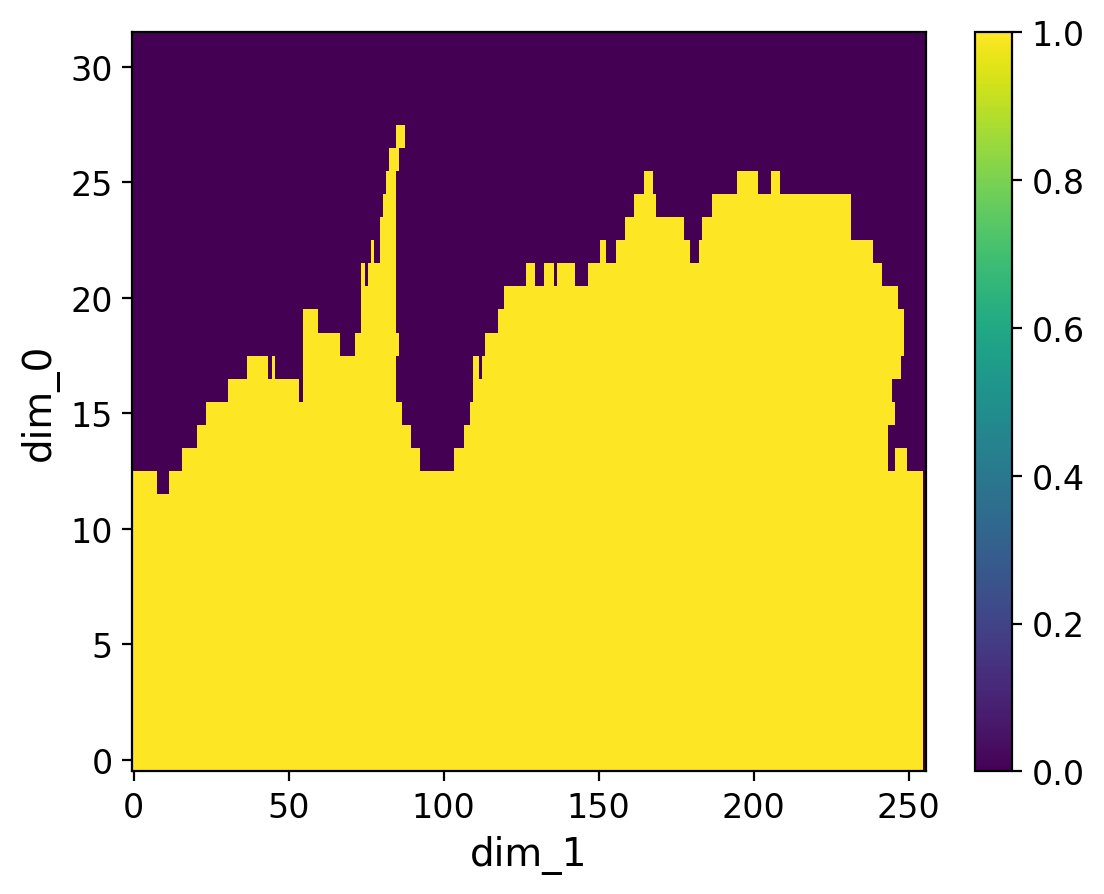

In [187]:
xr.DataArray(basins_3d[n]).plot()